Linear Discriminant Analysis


First lets import all libraries that we will later use.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
from mpl_toolkits.mplot3d import Axes3D

 Split ratio - defines proportion how should we split test data and training data 
 In this case 90% training data and 10 % test data

In [2]:
split_ratio = 0.9

 First create constructor for our LDA Classifier 
 data - our given data set 
 descriptor (dimensions)- this value defines how many eigen vectors we would choose to do the data sample projection 
 label_column - is data set column containing class labels for each sample

In [3]:
class LDA():
    def __init__(self, data, descriptors=1, label_column=-1):
        self.data = data
        self.descriptors = descriptors
        self.label_column = label_column

 Method is used for excluding label column from data set is needed

In [4]:
class LDA(LDA):    
    def remove_label_column(self, data, col):
        return data.drop(data.columns[[col]], axis=1)

 What we need is to do LDA parameter estimation 
 Procedure is like this:
     First we calculate means for each class
     Than we calculate the overall mean of all the data
     calculate between class covariance matrix - S_B = {N_i (m_i - m) (m_i - m).T}
     calculate within class covariance matrix - S_W = {S_i}; S_i = {(x - m_i) (x - m_i).T}
     What we do now is find eigenvalue, eigenvector pairs for inv(S_W).S_B
      sort the eigvals in decreasing order
      take first eigvectors that descrbe the biggest vairance in data, we choose to take first 3 becaause descriptor in our case is defined as 3
      return the LDA parameters - mean values and choosen eigenvectors

In [5]:
class LDA(LDA):    
    def estimate_lda_params(self, data):
        means = {}
        for c in self.classes:
            # calculate for columns
            tmp_data_mean = self.remove_label_column(self.class_data_samples[c], self.label_column).mean(axis=0)
            means[c] = np.array(tmp_data_mean)

        overall_mean = np.array(self.remove_label_column(data, self.label_column).mean(axis=0))

        # calculate between class covariance matrix
        S_B = np.zeros((data.shape[1] - 1, data.shape[1] - 1))
        for c in means.keys():
            N = len(self.class_data_samples[c])
            scatter_mean = np.outer((means[c] - overall_mean), (means[c] - overall_mean))
            S_B += np.multiply(N, scatter_mean)

        # calculate within class covariance matrix
        S_W = np.zeros(S_B.shape)
        for c in self.classes:
            class_data_transpose = self.remove_label_column(self.class_data_samples[c], self.label_column).T
            tmp_data = np.subtract(class_data_transpose, np.expand_dims(means[c], axis=1))  # taking away mean value
            cov_mat = np.cov(tmp_data)
            S_W = np.add(cov_mat, S_W)

        invSw_bySb = np.dot(np.linalg.pinv(S_W), S_B)
        eigvals, eigvecs = np.linalg.eig(invSw_bySb)
        eiglist = [(eigvals[i], eigvecs[:, i]) for i in range(len(eigvals))]

        # sort the eigvals in decreasing order
        eiglist = sorted(eiglist, key=lambda x: x[0], reverse=True)

        # take the first descriptors eigvectors
        w = np.array([eiglist[i][1] for i in range(self.descriptors)])

        self.w = w
        self.means = means
        return

 Now we define fit function 
 First group data based on the classes 
 Now we get how many unique classes are in our data set
 Next we go trough all the classes
     Now we get current class group with all it's sample data out of all groups
     we find indexes of each class sample data in the group 
     splitting bordder defines how we will divide class samples. 
     Which samples will go to test and which will go to training data.
     After the splitting is done we concatine data samples of each class together 
     Last step is to pass our training data to method that estimates LDA parameters

In [6]:
class LDA(LDA):    
    def fit(self):
        traindata = []
        testdata = []
        grouped = self.data.groupby(self.data.ix[:, self.label_column])

        self.classes = [c for c in grouped.groups.keys()]
        self.class_data_samples = {}
        for c in self.classes:
            self.class_data_samples[c] = grouped.get_group(c)
            index_list = list(self.class_data_samples[c].index)
            splitting_border = int(self.class_data_samples[c].shape[0] * split_ratio)
            rows = random.sample(index_list, splitting_border)
            traindata.append(self.class_data_samples[c].ix[rows])
            testdata.append(self.class_data_samples[c].drop(rows))

        traindata = pd.concat(traindata)
        testdata = pd.concat(testdata)

        # estimate the LDA parameters
        self.estimate_lda_params(traindata)

        return traindata, testdata


 Second phase is to create gaussian model
 Create method to estimate gaussian models for each class.
 Estimates priors, means and covariances for each class.
     We drop the label column for each class sample data 
     Next we project the data samples into the d dimension where d are the choosen dimensions in our case it is 3 
        Descriptor vectors (eigenvectors) are multiplied by Transposed class samples and than the result is again transposed
     Need to calculate projected data mean value, covariance matrix and priors for multi-variate Gaussian distribution

In [7]:
class LDA(LDA):    
    def gaussian_modeling(self):
        self.priors = {}
        self.gaussian_means = {}
        self.gaussian_cov = {}

        for c in self.means.keys():
            input_data = self.remove_label_column(self.class_data_samples[c], self.label_column)
            projection = np.dot(self.w, input_data.T).T
            self.priors[c] = input_data.shape[0] / float(self.data.shape[0])
            self.gaussian_means[c] = np.mean(projection, axis=0)
            self.gaussian_cov[c] = np.cov(projection, rowvar=False)

Methos that return the probability density function result for gaussian, given an samole projection point, gaussian mean and covariance.

In [8]:
class LDA(LDA):    
    def pdf(self, sample, mean, cov):
        cons = 1. / ((2 * np.pi) ** (len(sample) / 2.) * np.linalg.det(cov) ** (-0.5))
        exponent = np.exp(-np.dot(np.dot((sample - mean), np.linalg.inv(cov)), (sample - mean).T) / 2.)
        return cons * exponent

 Next step is to calculate Gaussian score or in other words maximum likelihood
 First we sort our data by classes
 Remove label column
 Calculate the likelihoods for each class based on our created gaussian models for this data set
 Maximum likelihood is calculated like this:
     Multiply class prior value with gausian probabilty density function for each projected sample point
 When that is done we choose sample points class label taking the biggest likelihood score
 After we calculate the error between actual class labels and expected class labels

In [9]:
class LDA(LDA):    
    def calculate_score_gaussian(self, data):
        classes = sorted(list(self.means.keys()))
        input_data = self.remove_label_column(data, self.label_column)
        projection = np.dot(self.w, input_data.T).T
        # calculate the likelihoods for each class based on the gaussian models
        likelihoods = np.array([
            [self.priors[c] * self.pdf(
                [x[index] for index in range(len(x))],
                self.gaussian_means[c],
                self.gaussian_cov[c])
             for c in classes]
            for x in projection])
        labels = np.argmax(likelihoods, axis=1)
        errors = np.sum(labels != data.ix[:, self.label_column])
        return errors

 Now we can visualize projections for the entire data in a 2D plot 

In [10]:
class LDA(LDA):    
    def plot_proj_2D(self, data):
        classes = list(self.means.keys())
        color_map = cm.rainbow(np.linspace(0, 1, len(classes)))
        plotlabels = {classes[c]: color_map[c] for c in range(len(classes))}

        fig = plt.figure()
        for i, row in data.iterrows():
            projection = np.dot(self.w, row[:self.label_column])
            projection = np.real(projection)
            plt.scatter(projection[0], projection[1], color=plotlabels[row[self.label_column]])
        plt.show()

 Now can do the same  but this time in a 3D plot

In [11]:
class LDA(LDA):    
    def plot_proj_3D(self, data):
        classes = list(self.means.keys())
        color_map = cm.rainbow(np.linspace(0, 1, len(classes)))
        plotlabels = {classes[c]: color_map[c] for c in range(len(classes))}

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for i, row in data.iterrows():
            projection = np.dot(self.w, row[:self.label_column])
            projection = np.real(projection)
            ax.scatter(projection[0],projection[1],projection[2],color=plotlabels[row[self.label_column]])
            #plt.scatter(projection[0], projection[1], color=plotlabels[row[self.label_column]])
        plt.show()

 In main method 
 We read or data set of digits 
 Create LDA classifier with 3 descriptors (dimensions)
 What we do next is estimate LDA Parameter's and return training and test data set
 Create gaussian model 
 Calculate test and training error
 Display data projection in 3D and 2D plots

/home/lin/PycharmProjects/LDA/venv/lib/python3.5/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
/home/lin/PycharmProjects/LDA/venv/lib/python3.5/site-packages/ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


/home/lin/PycharmProjects/LDA/venv/lib/python3.5/site-packages/ipykernel_launcher.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app


Training error: 0.009913258983890954
Test error 0.021505376344086023


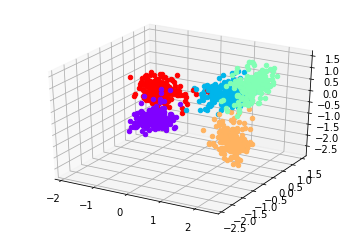

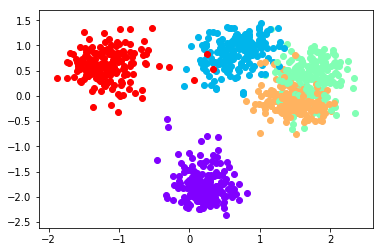

In [13]:
if __name__ == '__main__':
    data = pd.read_csv('digits.csv')
    data = data[data['0.29'] <= 4]
    lda = LDA(data, descriptors=3)
    traindata, testdata = lda.fit()

    lda.gaussian_modeling()
    trainerror = lda.calculate_score_gaussian(traindata) / float(traindata.shape[0])
    testerror = lda.calculate_score_gaussian(testdata) / float(testdata.shape[0])
    print('Training error:', trainerror)
    print('Test error', testerror)
    lda.plot_proj_3D(data)
    lda.plot_proj_2D(data)
